In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
# Loading digits dataset (8x8 images)
digits_data = load_digits()

In [3]:
# Preprocessing the data
# Reshaping 1d array into 3d array (channels, width, heigh) and normalizing it
x_data = digits_data["data"].reshape(-1,1,8,8) / 16.0
y_data = digits_data["target"]

In [4]:
# Dividing the data into train and test data
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.2)

8


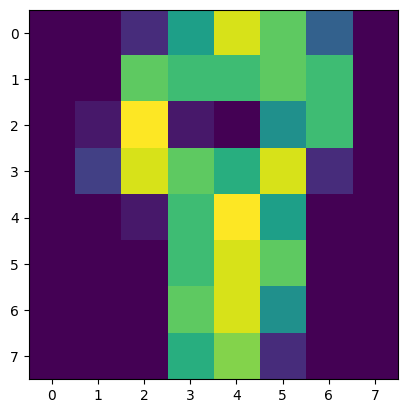

In [5]:
print(y_train[2])
plt.imshow(x_train[2][0])

In [6]:
# Creating dataset base of the preprocessed data
train_ds = torch.utils.data.TensorDataset(torch.from_numpy(x_train.astype(np.float32)),torch.tensor(y_train))
test_ds = torch.utils.data.TensorDataset(torch.from_numpy(x_test.astype(np.float32)),torch.tensor(y_test))

In [7]:
# Create dataloader (batched) of the dataset
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=16)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=16)

In [8]:
# Define the device to be used
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cpu


In [9]:
# Function to train the neural network model for one epoch (one loop over all items in the train dataset)
def train_one_epoch(model, train_dl, crit,optim):
    avg_loss = 0
    corrects = 0
    total = 0
    # Set the model in train mode
    model.train()
    # Loop over each x,y pair in the batched dataloader
    for x,y in train_dl:
        # Set the gradients of all parameters to zero
        optim.zero_grad()
        # Send x and y to the device that is being used now
        x = x.to(dev)
        y = y.to(dev)
        # Forward
        o = model(x)
        corrects += (torch.argmax(o,axis=1) == y).sum()
        total += len(y)
        # Calculate the loss
        l = crit(o,y)
        avg_loss += l.item()
        # Backward (calculate the gradient of loss with respect to each parameter)
        l.backward()
        # Update each parameter using the calculated gradient of the loss
        optim.step()
    return avg_loss / len(train_dl), 100*(corrects/total)

# Function to test the model over all item in the test dataset
def test_model(model, test_dl, crit):
    avg_loss = 0
    corrects = 0
    total = 0
    # Set the model in evaluation mode
    model.eval()
    # Loop over each x,y pair in the batched dataloader
    for x,y in test_dl:
        # Send x and y to the device that is being used now
        x = x.to(dev)
        y = y.to(dev)
        # Forward
        o = model(x)
        corrects += (torch.argmax(o,axis=1) == y).sum()
        total += len(y)
        # Calculate the loss
        l = crit(o,y)
        avg_loss += l.item()
    return avg_loss / len(train_dl), 100*(corrects/total)

In [10]:
# Merge all parameters of the neural network into a 1d array
def get_flat_parameters(model):
    w_ = []
    for w in model.parameters():
        w_.append(w.detach().reshape(-1).cpu().numpy())
    return np.concatenate(w_)

# Set the values of the 1d array input as the parameters of the neural network model 
def set_flat_parameters(model,params):
    i = 0
    for w in model.parameters():
        params_size = np.prod(w.data.shape)
        reshaped_params = params[i:i+params_size].reshape(w.data.shape)
        w.data = torch.from_numpy(reshaped_params)
        i += params_size

# Vary the parameters of the model along 2 main axis and calculate the loss
def generate_loss_map(model_base,test_dl, crit, w_1, w_2, x_mesh, y_mesh):
    z_mesh =[]
    model.eval()
    w_base = get_flat_parameters(model_base)
    for xi, yi in zip(x_mesh.reshape(-1),y_mesh.reshape(-1)):
        set_flat_parameters(model_base,w_base + xi * w_1 + yi * w_2)
        test_loss, test_acc = test_model(model_base, test_dl, crit)
        z_mesh.append(test_loss)
    return np.array(z_mesh).reshape(x_mesh.shape)

In [11]:
# Defining the neural network model and send it to the device
# MLP model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(8 * 8, 32),
    nn.ReLU(inplace=True),
    nn.Linear(32,10)
).to(dev)

# Defining the optimizer to be used to train the neural network model
optim = torch.optim.SGD(model.parameters(),lr=0.1)
# Defining our loss function
crit = torch.nn.CrossEntropyLoss()

In [12]:
param_history = []
train_history = []
# Trainig the model for 15 epochs
for epoch in tqdm.tqdm(range(15)):
    train_loss, train_acc = train_one_epoch(model,train_dl,crit,optim)
    test_loss, test_acc = test_model(model, test_dl, crit)
    param_history.append(get_flat_parameters(model))
    train_history.append([train_loss,train_acc,test_loss,test_acc])
    print(f"train_loss: {train_loss}, train_acc: {train_acc}, test_loss: {test_loss}, test_acc: {test_acc}")
param_history = np.array(param_history)
train_history = np.array(train_history)

 20%|████████████████▊                                                                   | 3/15 [00:00<00:01,  8.75it/s]

train_loss: 1.9122436973783705, train_acc: 52.8183708190918, test_loss: 0.34837983051935834, test_acc: 78.05555725097656
train_loss: 0.9171201099952062, train_acc: 82.60264587402344, test_loss: 0.16433275971147748, test_acc: 84.16666412353516
train_loss: 0.4670137365659078, train_acc: 90.53583526611328, test_loss: 0.10936175651020474, test_acc: 87.77777862548828


 33%|████████████████████████████                                                        | 5/15 [00:00<00:01,  9.07it/s]

train_loss: 0.3105164340800709, train_acc: 92.83229064941406, test_loss: 0.08489906754758623, test_acc: 90.83333587646484
train_loss: 0.23826460283663536, train_acc: 94.36325073242188, test_loss: 0.07136154365208414, test_acc: 91.94444274902344


 53%|████████████████████████████████████████████▊                                       | 8/15 [00:00<00:00,  9.71it/s]

train_loss: 0.19706450858049923, train_acc: 95.40709686279297, test_loss: 0.06283965719242891, test_acc: 92.5
train_loss: 0.1702940775702397, train_acc: 95.96381378173828, test_loss: 0.05714512798521254, test_acc: 93.6111068725586
train_loss: 0.15125913692431317, train_acc: 96.5205307006836, test_loss: 0.05311075006094244, test_acc: 94.44444274902344


 67%|███████████████████████████████████████████████████████▎                           | 10/15 [00:01<00:00,  9.20it/s]

train_loss: 0.13688601534813644, train_acc: 96.86847686767578, test_loss: 0.050042690792017515, test_acc: 95.0
train_loss: 0.1255656806131204, train_acc: 97.35560607910156, test_loss: 0.04763008223639594, test_acc: 95.0


 87%|███████████████████████████████████████████████████████████████████████▉           | 13/15 [00:01<00:00,  9.75it/s]

train_loss: 0.11631936474392811, train_acc: 97.56436920166016, test_loss: 0.04569308211406072, test_acc: 95.0
train_loss: 0.1086946730191509, train_acc: 97.56436920166016, test_loss: 0.04404621217399836, test_acc: 95.27777862548828
train_loss: 0.10213780720821686, train_acc: 97.63395690917969, test_loss: 0.04266352456890875, test_acc: 95.55555725097656


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.19it/s]

train_loss: 0.09636649418001374, train_acc: 97.63395690917969, test_loss: 0.040749963683386646, test_acc: 96.11111450195312
train_loss: 0.09147499811111225, train_acc: 97.84272766113281, test_loss: 0.04043794163606233, test_acc: 95.83332824707031


In [16]:
# If you have saved the model before
model.load_state_dict(torch.load("models/digits_mlp.ckpt"))

<All keys matched successfully>

prediction = 5, actual = 5


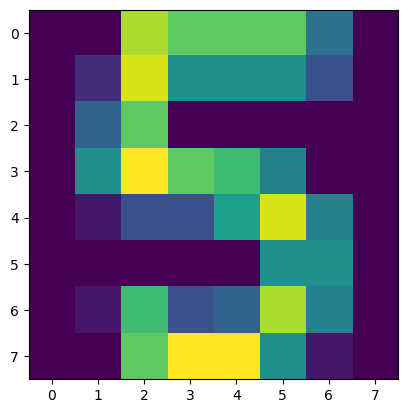

In [14]:
# Testing the model
x,y = test_ds[torch.randint(low=0,high=len(test_ds),size=(1,)).item()]
model.eval()
o = model(x.reshape((1,1,8,8)))
y_pred = torch.argmax(o,axis=1).item()
print(f"prediction = {y_pred}, actual = {y}")
plt.imshow(x[0])

In [15]:
# Saving our model
torch.save(model.state_dict(),"models/digits_mlp.ckpt")

In [17]:
# Calculate the main axis of the paraneters while training using PCA
# And reduce the dimenssion of the parameters to 2
pca = PCA(n_components=2)
param_history_reduced = pca.fit_transform(param_history)

In [18]:
# Generate a bidimensional mesh for exploring the loss function
X_mesh,Y_mesh = np.meshgrid(np.linspace(-7,7,20),np.linspace(-4,4,20))

In [19]:
# Calculate the loss function around the origin
Z_mesh = generate_loss_map(model,test_dl, crit, pca.components_[0], pca.components_[1], X_mesh, Y_mesh)

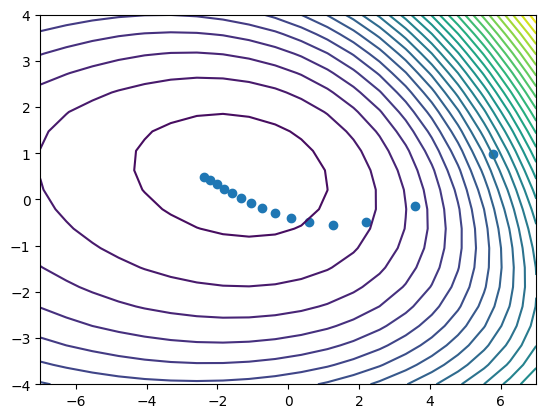

In [20]:
# Plot the contours and the evolution of the training
plt.contour(X_mesh,Y_mesh,Z_mesh,levels=40)
plt.scatter(*param_history_reduced.T)

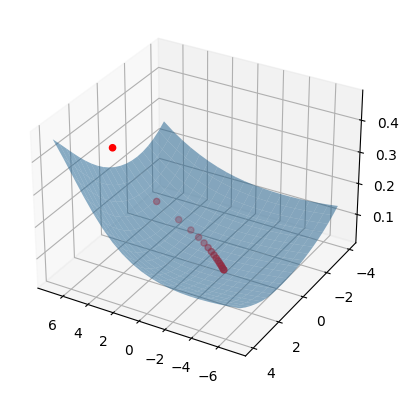

In [21]:
# Plot the surface and the evolution of the training
fig,ax = plt.subplots(subplot_kw={"projection":"3d"})
ax.view_init(30,120)
ax.plot_surface(X_mesh,Y_mesh,Z_mesh,alpha=0.5)
ax.scatter(param_history_reduced[:,0],param_history_reduced[:,1],train_history[:,2],color="red")

Text(0.5, 1.0, 'Loss')

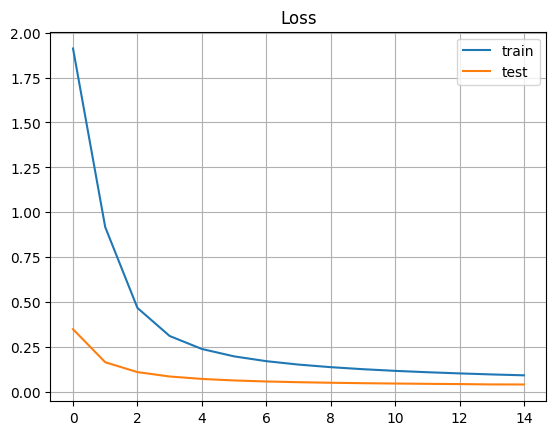

In [22]:
# Plot the loss evolution
plt.plot(train_history[:,0],label="train")
plt.plot(train_history[:,2],label="test")
plt.grid()
plt.legend()
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

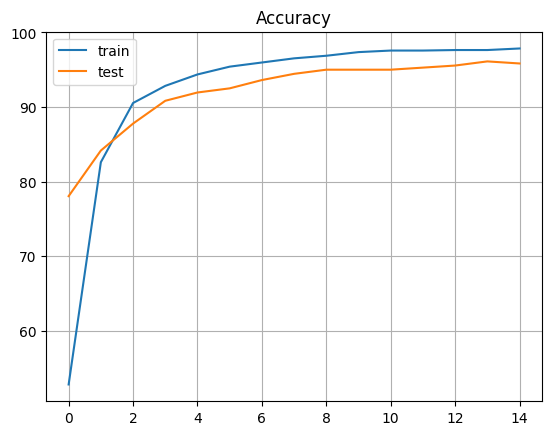

In [23]:
# Plot the accuracy evolution
plt.plot(train_history[:,1],label="train")
plt.plot(train_history[:,3],label="test")
plt.grid()
plt.legend()
plt.title("Accuracy")

In [24]:
# Function to create the convolutional layer (conv layer + relu + max pool)
def make_conv_layer(in_channels, out_channels, kernel_size):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
    )

In [25]:
# Defining the neural network model and send it to the device
# Conv model
model = nn.Sequential(
    make_conv_layer(1,16,5),
    nn.Flatten(),
    nn.Linear(16 * 2 * 2, 10)
).to(dev)

# Defining the optimizer to be used to train the neural network model
optim = torch.optim.SGD(model.parameters(),lr=0.1)
# Defining our loss function
crit = torch.nn.CrossEntropyLoss()

In [26]:
param_history = []
train_history = []
# Trainig the model for 15 epochs
for epoch in tqdm.tqdm(range(15)):
    train_loss, train_acc = train_one_epoch(model,train_dl,crit,optim)
    test_loss, test_acc = test_model(model, test_dl, crit)
    param_history.append(get_flat_parameters(model))
    train_history.append([train_loss,train_acc,test_loss,test_acc])
    print(f"train_loss: {train_loss}, train_acc: {train_acc}, test_loss: {test_loss}, test_acc: {test_acc}")
param_history = np.array(param_history)
train_history = np.array(train_history)

 13%|███████████▏                                                                        | 2/15 [00:00<00:02,  6.47it/s]

train_loss: 2.0384743438826667, train_acc: 38.204593658447266, test_loss: 0.38661598099602595, test_acc: 65.27777862548828
train_loss: 0.9887152840693791, train_acc: 80.44537353515625, test_loss: 0.15850609176688724, test_acc: 84.72222137451172


 27%|██████████████████████▍                                                             | 4/15 [00:00<00:01,  6.75it/s]

train_loss: 0.4778853464457724, train_acc: 88.9352798461914, test_loss: 0.09943856961197323, test_acc: 90.27777862548828
train_loss: 0.3228227362036705, train_acc: 91.9972152709961, test_loss: 0.07572325319051743, test_acc: 92.22222137451172


 40%|█████████████████████████████████▌                                                  | 6/15 [00:00<00:01,  6.78it/s]

train_loss: 0.2475870987607373, train_acc: 93.94571685791016, test_loss: 0.06285652758346663, test_acc: 93.6111068725586
train_loss: 0.20188328458203209, train_acc: 94.98956298828125, test_loss: 0.054670061750544445, test_acc: 94.16666412353516


 53%|████████████████████████████████████████████▊                                       | 8/15 [00:01<00:01,  6.94it/s]

train_loss: 0.17095494253767862, train_acc: 95.75504302978516, test_loss: 0.04930998517407311, test_acc: 94.72222137451172
train_loss: 0.14846360286076862, train_acc: 96.03340148925781, test_loss: 0.045526527220176326, test_acc: 94.72222137451172


 67%|███████████████████████████████████████████████████████▎                           | 10/15 [00:01<00:00,  6.66it/s]

train_loss: 0.13120466857734653, train_acc: 96.79888153076172, test_loss: 0.04271766808297899, test_acc: 94.72222137451172
train_loss: 0.1177145970157451, train_acc: 97.21642303466797, test_loss: 0.040533685539331704, test_acc: 95.27777862548828


 80%|██████████████████████████████████████████████████████████████████▍                | 12/15 [00:01<00:00,  6.61it/s]

train_loss: 0.10685420429541005, train_acc: 97.35560607910156, test_loss: 0.038754631951451304, test_acc: 95.27777862548828
train_loss: 0.09784197995646132, train_acc: 97.77313995361328, test_loss: 0.037203304635153873, test_acc: 95.27777862548828


 93%|█████████████████████████████████████████████████████████████████████████████▍     | 14/15 [00:02<00:00,  6.80it/s]

train_loss: 0.09033643166638083, train_acc: 97.91231536865234, test_loss: 0.03596232711440987, test_acc: 95.27777862548828
train_loss: 0.08385387057852414, train_acc: 98.190673828125, test_loss: 0.03473406388527817, test_acc: 95.55555725097656


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.67it/s]

train_loss: 0.07818838720106416, train_acc: 98.3298568725586, test_loss: 0.033618146708856024, test_acc: 95.55555725097656


In [ ]:
# If you have saved the model before
model.load_state_dict(torch.load("models/digits_cnn.ckpt"))

prediction = 7, actual = 7


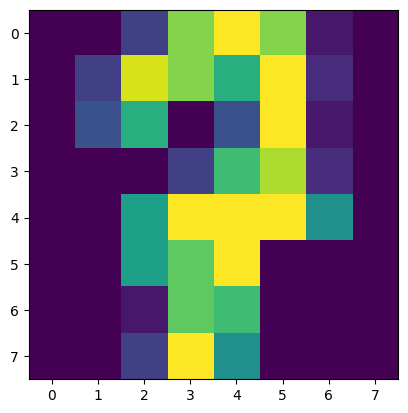

In [27]:
# Testing the model
x,y = test_ds[torch.randint(low=0,high=len(test_ds),size=(1,)).item()]
model.eval()
o = model(x.reshape((1,1,8,8)))
y_pred = torch.argmax(o,axis=1).item()
print(f"prediction = {y_pred}, actual = {y}")
plt.imshow(x[0])

In [28]:
# Saving our model
torch.save(model.state_dict(),"models/digits_cnn.ckpt")

In [29]:
# Calculate the main axis of the paraneters while training using PCA
# And reduce the dimenssion of the parameters to 2
pca = PCA(n_components=2)
param_history_reduced = pca.fit_transform(param_history)

In [30]:
# Generate a bidimensional mesh for exploring the loss function
X_mesh,Y_mesh = np.meshgrid(np.linspace(-7,7,20),np.linspace(-4,4,20))

In [31]:
# Calculate the loss function around the origin
Z_mesh = generate_loss_map(model,test_dl, crit, pca.components_[0], pca.components_[1], X_mesh, Y_mesh)

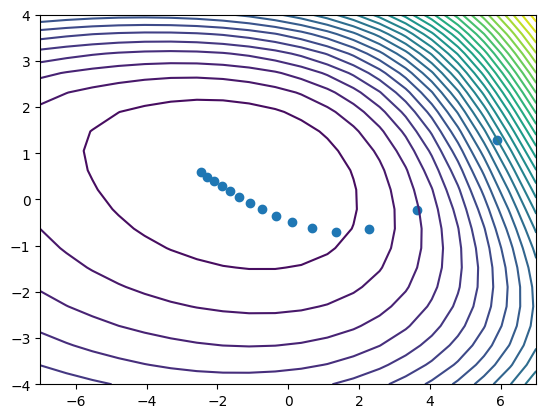

In [32]:
# Plot the contours and the evolution of the training
plt.contour(X_mesh,Y_mesh,Z_mesh,levels=40)
plt.scatter(*param_history_reduced.T)

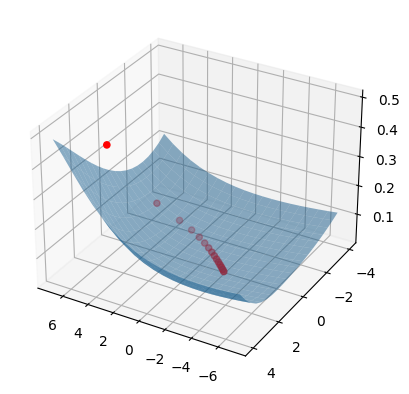

In [33]:
# Plot the surface and the evolution of the training
fig,ax = plt.subplots(subplot_kw={"projection":"3d"})
ax.view_init(30,120)
ax.plot_surface(X_mesh,Y_mesh,Z_mesh,alpha=0.5)
ax.scatter(param_history_reduced[:,0],param_history_reduced[:,1],train_history[:,2],color="red")

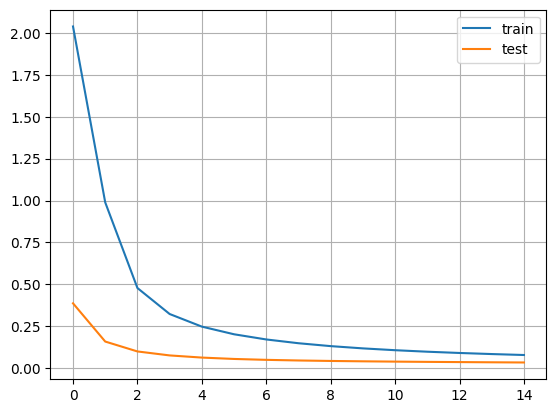

In [34]:
# Plot the loss evolution
plt.plot(train_history[:,0],label="train")
plt.plot(train_history[:,2],label="test")
plt.grid()
plt.legend()

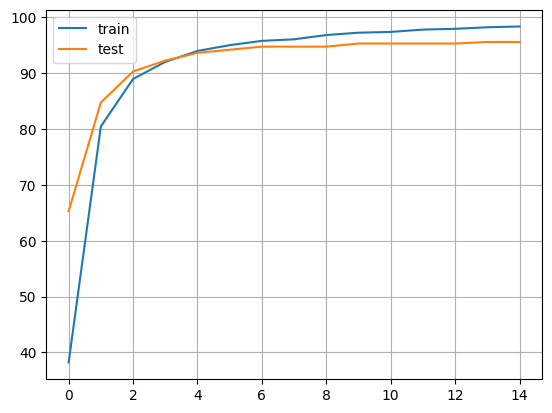

In [35]:
# Plot the accuracy evolution
plt.plot(train_history[:,1],label="train")
plt.plot(train_history[:,3],label="test")
plt.grid()
plt.legend()

In [36]:
# Class to create a Residual layer 
class ResidualBlock(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size):
        super(ResidualBlock,self).__init__()
        self.direct = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=1)
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=2)
        )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        o = self.direct(x)
        s = self.shortcut(x)
        return self.relu(o + s)

In [37]:
# Defining our neural network model (Residual Network)
model = nn.Sequential(
    ResidualBlock(1,16,3),
    ResidualBlock(16,32,3),
    nn.Flatten(),
    nn.Linear(32,10)
)

# Defining our optimizer (SGD: Stochastic Gradient Descent)
optim = torch.optim.SGD(model.parameters(),lr=0.1)
# Defining our loss function
crit = torch.nn.CrossEntropyLoss()

In [38]:
param_history = []
train_history = []
# Trainig the model for 15 epochs
for epoch in tqdm.tqdm(range(15)):
    train_loss, train_acc = train_one_epoch(model,train_dl,crit,optim)
    test_loss, test_acc = test_model(model, test_dl, crit)
    param_history.append(get_flat_parameters(model))
    train_history.append([train_loss,train_acc,test_loss,test_acc])
    print(f"train_loss: {train_loss}, train_acc: {train_acc}, test_loss: {test_loss}, test_acc: {test_acc}")
param_history = np.array(param_history)
train_history = np.array(train_history)

  7%|█████▌                                                                              | 1/15 [00:00<00:03,  3.68it/s]

train_loss: 1.8431651426686182, train_acc: 40.9185791015625, test_loss: 0.2756105889876684, test_acc: 62.777774810791016


 13%|███████████▏                                                                        | 2/15 [00:00<00:03,  3.62it/s]

train_loss: 0.6967631191015243, train_acc: 78.9144058227539, test_loss: 0.12259275847011142, test_acc: 84.44444274902344


 20%|████████████████▊                                                                   | 3/15 [00:00<00:03,  3.45it/s]

train_loss: 0.3667014324830638, train_acc: 88.65692901611328, test_loss: 0.07529483156071769, test_acc: 91.94444274902344


 27%|██████████████████████▍                                                             | 4/15 [00:01<00:03,  3.31it/s]

train_loss: 0.2415248845393459, train_acc: 92.41475677490234, test_loss: 0.052911007445719506, test_acc: 94.72222137451172


 33%|████████████████████████████                                                        | 5/15 [00:01<00:03,  3.22it/s]

train_loss: 0.18010875813456045, train_acc: 94.50243377685547, test_loss: 0.04288474896715747, test_acc: 95.0


 40%|█████████████████████████████████▌                                                  | 6/15 [00:01<00:02,  3.06it/s]

train_loss: 0.14602456749416887, train_acc: 94.78079223632812, test_loss: 0.03925637480699354, test_acc: 95.27777862548828


 47%|███████████████████████████████████████▏                                            | 7/15 [00:02<00:02,  2.99it/s]

train_loss: 0.119237067995386, train_acc: 95.96381378173828, test_loss: 0.036697657064845166, test_acc: 95.55555725097656


 53%|████████████████████████████████████████████▊                                       | 8/15 [00:02<00:02,  3.10it/s]

train_loss: 0.09696510050238835, train_acc: 97.0772476196289, test_loss: 0.035460735329737265, test_acc: 95.55555725097656


 60%|██████████████████████████████████████████████████▍                                 | 9/15 [00:02<00:01,  3.13it/s]

train_loss: 0.07861777509873112, train_acc: 97.56436920166016, test_loss: 0.03160654837783012, test_acc: 95.83332824707031


 67%|███████████████████████████████████████████████████████▎                           | 10/15 [00:03<00:01,  3.16it/s]

train_loss: 0.06659351583156321, train_acc: 97.91231536865234, test_loss: 0.030864684878745014, test_acc: 96.11111450195312


 73%|████████████████████████████████████████████████████████████▊                      | 11/15 [00:03<00:01,  3.34it/s]

train_loss: 0.05661694391941031, train_acc: 98.46903228759766, test_loss: 0.029972939715824192, test_acc: 96.66666412353516


 80%|██████████████████████████████████████████████████████████████████▍                | 12/15 [00:03<00:00,  3.45it/s]

train_loss: 0.04601612823122802, train_acc: 98.74739074707031, test_loss: 0.02994738887064159, test_acc: 96.66666412353516


 87%|███████████████████████████████████████████████████████████████████████▉           | 13/15 [00:04<00:00,  3.26it/s]

train_loss: 0.03979203379195598, train_acc: 99.0953369140625, test_loss: 0.0312967930519436, test_acc: 96.66666412353516


 93%|█████████████████████████████████████████████████████████████████████████████▍     | 14/15 [00:04<00:00,  3.18it/s]

train_loss: 0.033809784069631456, train_acc: 99.0953369140625, test_loss: 0.03269564684661519, test_acc: 96.66666412353516


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.22it/s]

train_loss: 0.032295807856199746, train_acc: 99.0953369140625, test_loss: 0.03479096232202007, test_acc: 95.27777862548828


In [45]:
# If you have saved the model before
model.load_state_dict(torch.load("models/digits_resnet.ckpt"))

<All keys matched successfully>

prediction = 6, actual = 6


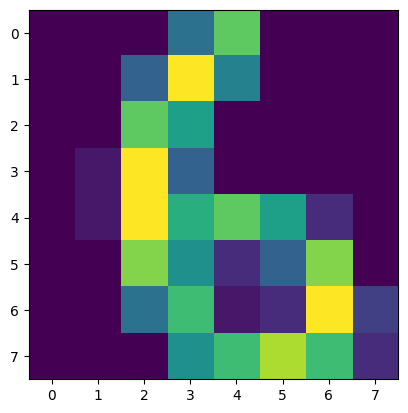

In [43]:
# Testing the model
x,y = test_ds[torch.randint(low=0,high=len(test_ds),size=(1,)).item()]
model.eval()
o = model(x.reshape((1,1,8,8)))
y_pred = torch.argmax(o,axis=1).item()
print(f"prediction = {y_pred}, actual = {y}")
plt.imshow(x[0])

In [44]:
# Saving our model
torch.save(model.state_dict(),"models/digits_resnet.ckpt")

In [46]:
# Calculate the main axis of the paraneters while training using PCA
# And reduce the dimenssion of the parameters to 2
pca = PCA(n_components=2)
param_history_reduced = pca.fit_transform(param_history)

In [47]:
# Generate a bidimensional mesh for exploring the loss function
X_mesh,Y_mesh = np.meshgrid(np.linspace(-7,7,10),np.linspace(-4,4,10))

In [48]:
# Calculate the loss function around the origin
Z_mesh = generate_loss_map(model,test_dl, crit, pca.components_[0], pca.components_[1], X_mesh, Y_mesh)

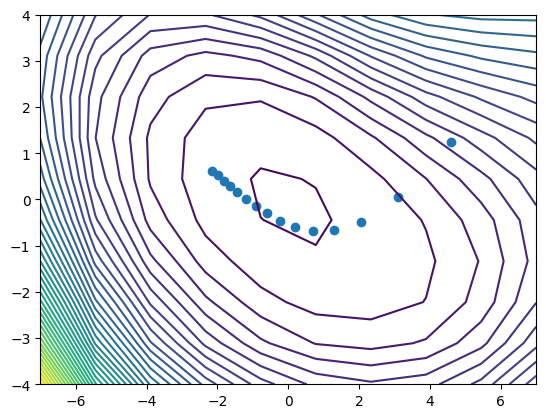

In [49]:
# Plot the contours and the evolution of the training
plt.contour(X_mesh,Y_mesh,Z_mesh,levels=40)
plt.scatter(*param_history_reduced.T)

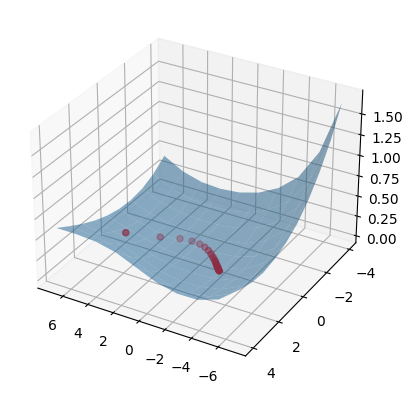

In [50]:
# Plot the surface and the evolution of the training
fig,ax = plt.subplots(subplot_kw={"projection":"3d"})
ax.view_init(30,120)
ax.plot_surface(X_mesh,Y_mesh,Z_mesh,alpha=0.5)
ax.scatter(param_history_reduced[:,0],param_history_reduced[:,1],train_history[:,2],color="red")

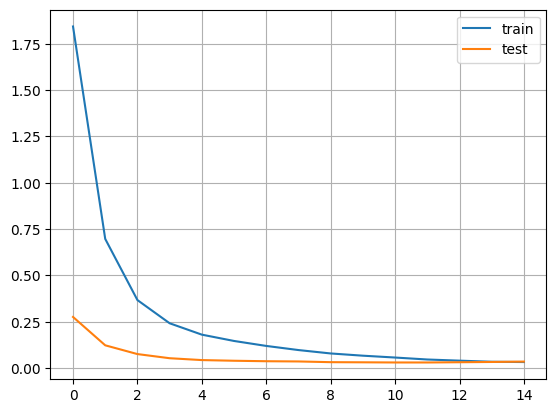

In [51]:
# Plot the loss evolution
plt.plot(train_history[:,0],label="train")
plt.plot(train_history[:,2],label="test")
plt.grid()
plt.legend()

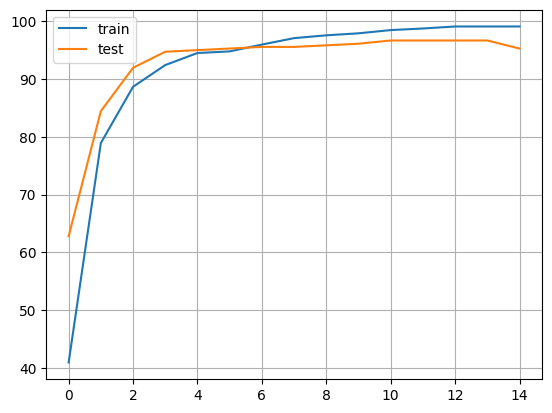

In [52]:
# Plot the accuracy evolution
plt.plot(train_history[:,1],label="train")
plt.plot(train_history[:,3],label="test")
plt.grid()
plt.legend()